# Load libraries and set device up

In [28]:
import matplotlib.pyplot as plt
import numpy             as np
import seaborn           as sns
import torch.nn          as nn
import os
import torch
import json

import libraries.model   as clm
import libraries.dataset as cld

from libraries.dataset      import generate_dataset, standardize_dataset
from libraries.model        import GCNN, train, test, EarlyStopping
from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

# Define parameters

In [2]:
n_epochs      = 300
batch_size    = 128
learning_rate = 0.001
dropout       = 0.1
patience      = 10
delta         = 2
train_ratio   = 0.9
test_ratio    = 0.05  # val_ratio = 1 - train_ratio - test_ratio

dpi = 50

target = 'EPA'
folder = 'MP-EPA-deep'

input_folder  = 'models'
target_folder = f'{input_folder}/{folder}'
model_name    = f'{target_folder}/{target}-model.pt'

# Generate or load graph database for training

In [3]:
labels_name                  = f'{target_folder}/labels.pt'
dataset_name                 = f'{target_folder}/dataset.pt'
dataset_name_std             = f'{target_folder}/standardized_dataset.pt'
labels_name_std              = f'{target_folder}/standardized_labels.pt'
standardized_parameters_name = f'{target_folder}/standardized_parameters.json'  # Parameters for rescaling the predictions

if not any(os.path.exists(path) for path in [dataset_name_std, standardized_parameters_name, labels_name_std, dataset_name, labels_name]):
    # Generate data
    generate_dataset('/home/claudio/cibran/Work/UPC/CLUE/Loaded_PhaseTransition',
                     targets=['EPA', 'bandgap'],
                     data_folder=target_folder)

if all(os.path.exists(path) for path in [dataset_name_std, standardized_parameters_name, labels_name_std]):
    # Load the standardized dataset, with corresponding labels and parameters
    dataset = torch.load(dataset_name_std)
    labels  = torch.load(labels_name_std)
    
    # Load the data from the JSON file
    with open(standardized_parameters_name, 'r') as json_file:
        numpy_dict = json.load(json_file)
    
    # Convert torch tensors to numpy arrays
    standardized_parameters = {}
    for key, value in numpy_dict.items():
        try:
            standardized_parameters[key] = torch.tensor(value)
        except:
            standardized_parameters[key] = value

elif all(os.path.exists(path) for path in [dataset_name, labels_name]):
    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(dataset_name)
    labels  = torch.load(labels_name)
    
    # Standardize dataset
    dataset, labels, standardized_parameters = standardize_dataset(dataset, labels)
    
    # Save standardized dataset
    torch.save(dataset, dataset_name_std)
    torch.save(labels,  labels_name_std)
    
    # Convert torch tensors to numpy arrays
    numpy_dict = {}
    for key, value in standardized_parameters.items():
        try:
            numpy_dict[key] = value.cpu().numpy().tolist()
        except:
            numpy_dict[key] = value
    
    # Dump the dictionary with numpy arrays to a JSON file
    with open(standardized_parameters_name, 'w') as json_file:
        json.dump(numpy_dict, json_file)  

# Load the data from the JSON file
with open(f'{target_folder}/dataset_parameters.json', 'r') as json_file:
    dataset_parameters = json.load(json_file)

# Determine the index for the desired property
target_idx = [idx for idx, t in enumerate(dataset_parameters['target']) if t == target][0]
standardized_parameters['target_mean'] = standardized_parameters['target_mean'][target_idx]
standardized_parameters['target_std']  = standardized_parameters['target_std'][target_idx]

# Defining target factor
target_factor = standardized_parameters['target_std'] / standardized_parameters['scale']

# Select the target we want
for data in dataset:
    data.y = data.y[target_idx]

/tmp/ipykernel_652427/1108331434.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(dataset_name)
/tmp/ipykernel_652427/1108331434.py:33: FutureWarnin

Split dataset

In [4]:
# Define the sizes of the train and test sets
# Corresponds to the size wrt the number of unique materials in the dataset
train_size = int(train_ratio * len(dataset))
test_size  = int(test_ratio  * len(dataset))

np.random.shuffle(dataset)

# Random, fast splitting
train_dataset = dataset[:train_size]
val_dataset   = dataset[train_size:-test_size]
test_dataset  = dataset[-test_size:]

train_labels = labels[:train_size]
val_labels   = labels[train_size:-test_size]
test_labels  = labels[-test_size:]

#uncer_dataset_std = [data for dset in [train_dataset, val_dataset] for data in dset]
#uncer_labels_std  = [data for dset in [train_labels,  val_labels]  for data in dset]

#torch.save(uncer_dataset_std, f'{target_folder}/uncer_dataset_std.pt')
#torch.save(uncer_labels_std,  f'{target_folder}/uncer_labels_std.pt')

torch.save(train_dataset, f'{target_folder}/train_dataset_std.pt')
torch.save(train_labels,  f'{target_folder}/train_labels_std.pt')

torch.save(test_dataset, f'{target_folder}/test_dataset_std.pt')
torch.save(test_labels,  f'{target_folder}/test_labels_std.pt')

del dataset  # Free up CUDA memory

print(f'Number of training   graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of testing    graphs: {len(test_dataset)}')

Number of training   graphs: 40500
Number of validation graphs: 2250
Number of testing    graphs: 2250


Define data loaders.

In [5]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset[0].num_node_features

#del train_dataset, val_dataset, test_dataset  # Free up CUDA memory

# Generate Graph Neural Network model

In [6]:
model = GCNN(features_channels=n_node_features,
                 pdropout=dropout)

# Moving model to device
model = model.to(device)

if os.path.exists(f'{target_folder}/{target}-model.pt'):
    model.load_state_dict(torch.load(f'{target_folder}/{target}-model.pt'))
    model.train()

# Allow data parallelization among multi-GPU
model= nn.DataParallel(model)
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (linconv1): Linear(in_features=32, out_features=32, bias=True)
    (linconv2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion 

In [7]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = EarlyStopping(patience=patience, delta=delta, model_name=model_name)

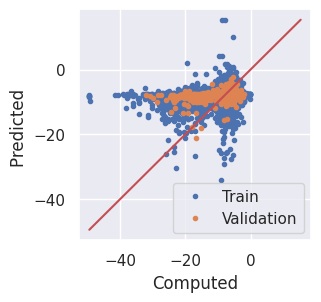

Epoch: 1, Train MAE: 3.3626, Val MAE: 3.3718
Epoch: 2, Train MAE: 3.2683, Val MAE: 3.3463
Epoch: 3, Train MAE: 3.2373, Val MAE: 3.3527
Epoch: 4, Train MAE: 3.2322, Val MAE: 3.3459
Epoch: 5, Train MAE: 3.2064, Val MAE: 3.3424


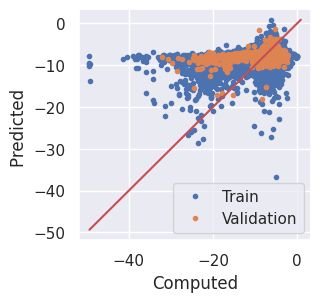

Epoch: 6, Train MAE: 3.1980, Val MAE: 3.3358
Epoch: 7, Train MAE: 3.1870, Val MAE: 3.3175
Epoch: 8, Train MAE: 3.1799, Val MAE: 3.3166
Epoch: 9, Train MAE: 3.1546, Val MAE: 3.2702
Epoch: 10, Train MAE: 3.1457, Val MAE: 3.2698


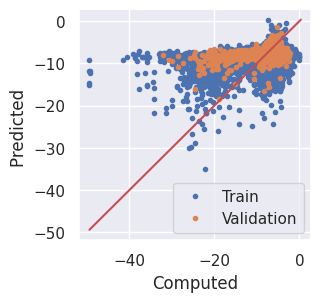

Epoch: 11, Train MAE: 3.1359, Val MAE: 3.2745
Epoch: 12, Train MAE: 3.1308, Val MAE: 3.2540
Epoch: 13, Train MAE: 3.1232, Val MAE: 3.2633
Epoch: 14, Train MAE: 3.1126, Val MAE: 3.2336
Epoch: 15, Train MAE: 3.1035, Val MAE: 3.2411


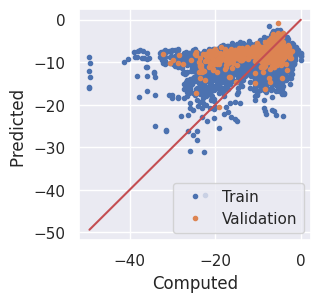

Epoch: 16, Train MAE: 3.1017, Val MAE: 3.2295
Epoch: 17, Train MAE: 3.0959, Val MAE: 3.2284
Epoch: 18, Train MAE: 3.0968, Val MAE: 3.2290
Epoch: 19, Train MAE: 3.0830, Val MAE: 3.2098
Epoch: 20, Train MAE: 3.0684, Val MAE: 3.2090


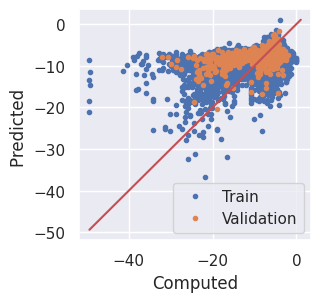

Epoch: 21, Train MAE: 3.0615, Val MAE: 3.2029
Epoch: 22, Train MAE: 3.0644, Val MAE: 3.2072
Epoch: 23, Train MAE: 3.0912, Val MAE: 3.1862
Epoch: 24, Train MAE: 3.0526, Val MAE: 3.1719
Epoch: 25, Train MAE: 3.0420, Val MAE: 3.1820


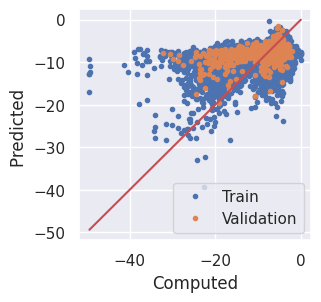

Epoch: 26, Train MAE: 3.0399, Val MAE: 3.1681
Epoch: 27, Train MAE: 3.0393, Val MAE: 3.1159
Epoch: 28, Train MAE: 3.0388, Val MAE: 3.1777
Epoch: 29, Train MAE: 3.0324, Val MAE: 3.1514
Epoch: 30, Train MAE: 3.0281, Val MAE: 3.1362


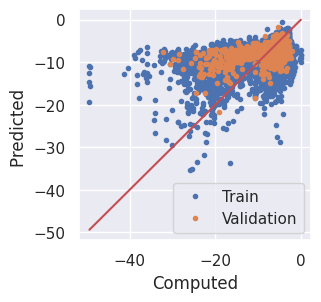

Epoch: 31, Train MAE: 3.0152, Val MAE: 3.1326
Epoch: 32, Train MAE: 3.0169, Val MAE: 3.1244
Epoch: 33, Train MAE: 3.0105, Val MAE: 3.1444
Epoch: 34, Train MAE: 2.9990, Val MAE: 3.1450
Epoch: 35, Train MAE: 3.0031, Val MAE: 3.1253


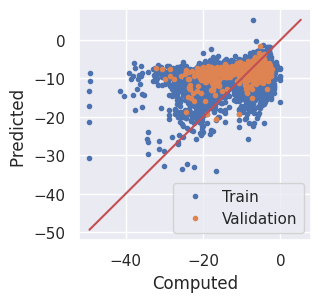

Epoch: 36, Train MAE: 2.9980, Val MAE: 3.1636
Epoch: 37, Train MAE: 2.9928, Val MAE: 3.1285
Epoch: 38, Train MAE: 2.9828, Val MAE: 3.1154
Epoch: 39, Train MAE: 2.9792, Val MAE: 3.1345
Epoch: 40, Train MAE: 2.9976, Val MAE: 3.1490


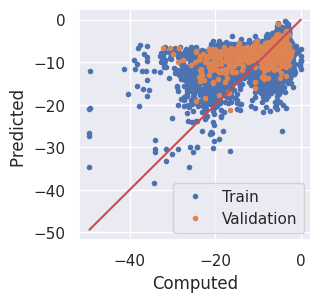

Epoch: 41, Train MAE: 2.9730, Val MAE: 3.1118
Epoch: 42, Train MAE: 2.9654, Val MAE: 3.0966
Epoch: 43, Train MAE: 2.9674, Val MAE: 3.1185
Epoch: 44, Train MAE: 2.9443, Val MAE: 3.1172
Epoch: 45, Train MAE: 2.9487, Val MAE: 3.0866


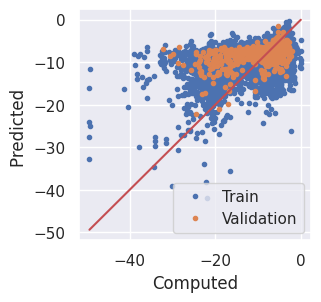

Epoch: 46, Train MAE: 2.9481, Val MAE: 3.1182
Epoch: 47, Train MAE: 2.9435, Val MAE: 3.1032
Epoch: 48, Train MAE: 2.9422, Val MAE: 3.0971
Epoch: 49, Train MAE: 2.9299, Val MAE: 3.0694
Epoch: 50, Train MAE: 2.9288, Val MAE: 3.0818


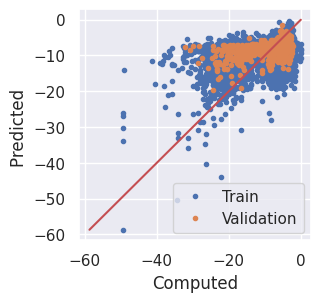

Epoch: 51, Train MAE: 2.9309, Val MAE: 3.0832
Epoch: 52, Train MAE: 2.9234, Val MAE: 3.1063
Epoch: 53, Train MAE: 2.9217, Val MAE: 3.1053
Epoch: 54, Train MAE: 2.9196, Val MAE: 3.0458
Epoch: 55, Train MAE: 2.9014, Val MAE: 3.0841


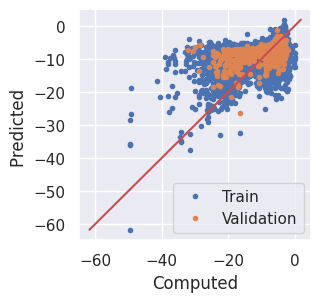

Epoch: 56, Train MAE: 2.9001, Val MAE: 3.0699
Epoch: 57, Train MAE: 2.8890, Val MAE: 3.0480
Epoch: 58, Train MAE: 2.9227, Val MAE: 3.1047
Epoch: 59, Train MAE: 2.9046, Val MAE: 3.0607
Epoch: 60, Train MAE: 2.8876, Val MAE: 3.0645


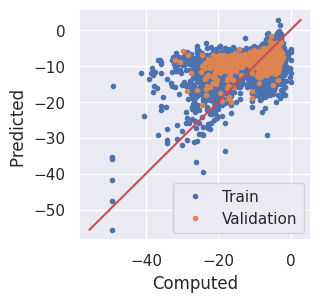

Epoch: 61, Train MAE: 2.8996, Val MAE: 3.0330
Epoch: 62, Train MAE: 2.8919, Val MAE: 3.0262
Epoch: 63, Train MAE: 2.8896, Val MAE: 3.0546
Epoch: 64, Train MAE: 2.8823, Val MAE: 3.0539
Epoch: 65, Train MAE: 2.8909, Val MAE: 3.0117


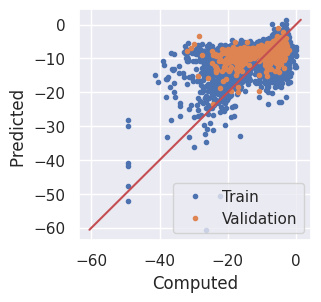

Epoch: 66, Train MAE: 2.8659, Val MAE: 3.0737
Epoch: 67, Train MAE: 2.8838, Val MAE: 3.0290
Epoch: 68, Train MAE: 2.8826, Val MAE: 3.0186
Epoch: 69, Train MAE: 2.8987, Val MAE: 3.0972
Epoch: 70, Train MAE: 2.8744, Val MAE: 3.0139


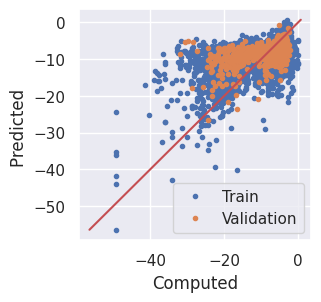

Epoch: 71, Train MAE: 2.8529, Val MAE: 3.0515
Epoch: 72, Train MAE: 2.8642, Val MAE: 3.0285
Epoch: 73, Train MAE: 2.8636, Val MAE: 3.0476
Epoch: 74, Train MAE: 2.8636, Val MAE: 3.0560
Epoch: 75, Train MAE: 2.9405, Val MAE: 3.0521


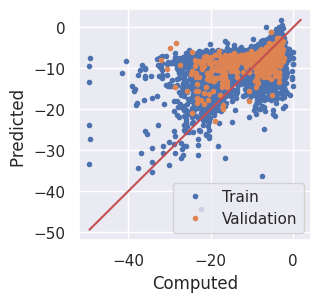

Epoch: 76, Train MAE: 2.8962, Val MAE: 3.0249
Epoch: 77, Train MAE: 2.8526, Val MAE: 3.0088
Epoch: 78, Train MAE: 2.8408, Val MAE: 3.0111
Epoch: 79, Train MAE: 2.8507, Val MAE: 3.0258
Epoch: 80, Train MAE: 2.8434, Val MAE: 3.0157


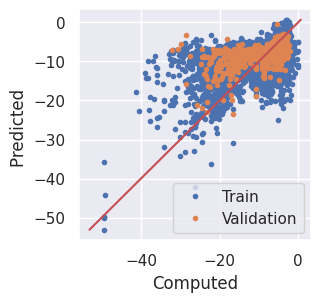

Epoch: 81, Train MAE: 2.8413, Val MAE: 3.0105
Epoch: 82, Train MAE: 2.8556, Val MAE: 3.0029
Epoch: 83, Train MAE: 2.8269, Val MAE: 3.0334
Epoch: 84, Train MAE: 2.8250, Val MAE: 3.0211
Epoch: 85, Train MAE: 2.8465, Val MAE: 3.0063


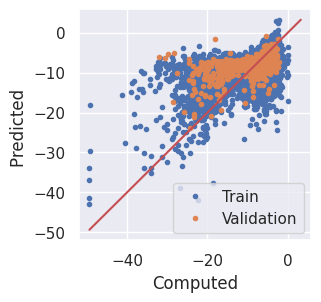

Epoch: 86, Train MAE: 2.8386, Val MAE: 3.0183
Epoch: 87, Train MAE: 2.9098, Val MAE: 3.0310
Epoch: 88, Train MAE: 2.8501, Val MAE: 3.0137
Epoch: 89, Train MAE: 2.8314, Val MAE: 3.0423
Epoch: 90, Train MAE: 2.8265, Val MAE: 2.9812


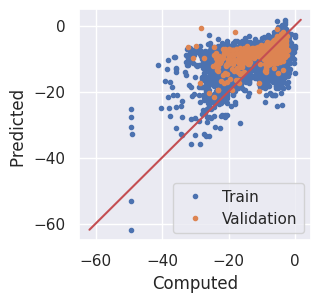

Epoch: 91, Train MAE: 2.8276, Val MAE: 3.0042
Epoch: 92, Train MAE: 2.8174, Val MAE: 3.0224
Epoch: 93, Train MAE: 2.8563, Val MAE: 3.0629
Epoch: 94, Train MAE: 2.8375, Val MAE: 3.0259
Epoch: 95, Train MAE: 2.8302, Val MAE: 2.9938


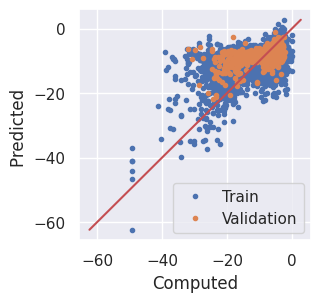

Epoch: 96, Train MAE: 2.8157, Val MAE: 3.0013
Epoch: 97, Train MAE: 2.8065, Val MAE: 3.0242
Epoch: 98, Train MAE: 2.8035, Val MAE: 2.9610
Epoch: 99, Train MAE: 2.8126, Val MAE: 3.0417
Epoch: 100, Train MAE: 2.8192, Val MAE: 3.0298


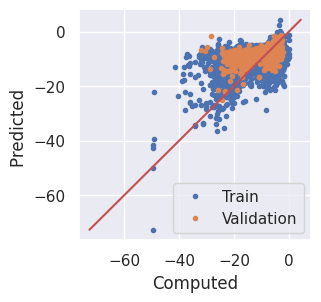

Epoch: 101, Train MAE: 2.8260, Val MAE: 3.0001
Epoch: 102, Train MAE: 2.8065, Val MAE: 3.0077
Epoch: 103, Train MAE: 2.8155, Val MAE: 3.0590
Epoch: 104, Train MAE: 2.8092, Val MAE: 3.0224
Epoch: 105, Train MAE: 2.8007, Val MAE: 3.0046


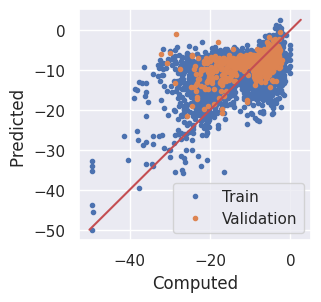

Epoch: 106, Train MAE: 2.8005, Val MAE: 3.0375
Epoch: 107, Train MAE: 2.8070, Val MAE: 3.0266
Epoch: 108, Train MAE: 2.7905, Val MAE: 2.9813
Epoch: 109, Train MAE: 2.7943, Val MAE: 3.0075
Epoch: 110, Train MAE: 2.7918, Val MAE: 3.0330


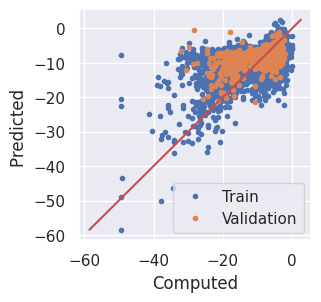

Epoch: 111, Train MAE: 2.7992, Val MAE: 3.0179
Epoch: 112, Train MAE: 2.7871, Val MAE: 3.0243
Epoch: 113, Train MAE: 2.7904, Val MAE: 3.0212
Epoch: 114, Train MAE: 2.7687, Val MAE: 3.0530
Epoch: 115, Train MAE: 2.7944, Val MAE: 3.0422


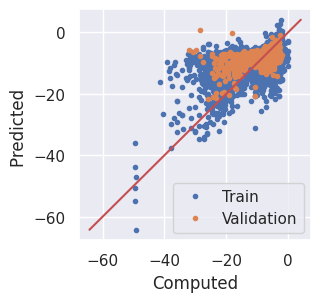

Epoch: 116, Train MAE: 2.7841, Val MAE: 3.0373
Epoch: 117, Train MAE: 2.8276, Val MAE: 3.0719
Epoch: 118, Train MAE: 2.8097, Val MAE: 3.0656
Epoch: 119, Train MAE: 2.8250, Val MAE: 3.0363
Epoch: 120, Train MAE: 2.7753, Val MAE: 2.9987


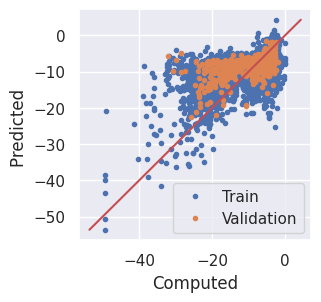

Epoch: 121, Train MAE: 2.7727, Val MAE: 2.9850
Epoch: 122, Train MAE: 2.7789, Val MAE: 2.9877
Epoch: 123, Train MAE: 2.7626, Val MAE: 3.0224
Epoch: 124, Train MAE: 2.7696, Val MAE: 2.9964
Epoch: 125, Train MAE: 2.7695, Val MAE: 3.0506


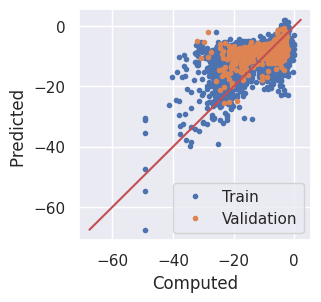

Epoch: 126, Train MAE: 2.7726, Val MAE: 2.9900
Epoch: 127, Train MAE: 2.7809, Val MAE: 3.0295
Epoch: 128, Train MAE: 2.7605, Val MAE: 3.0673
Epoch: 129, Train MAE: 2.7749, Val MAE: 3.0050
Epoch: 130, Train MAE: 2.7595, Val MAE: 3.0067


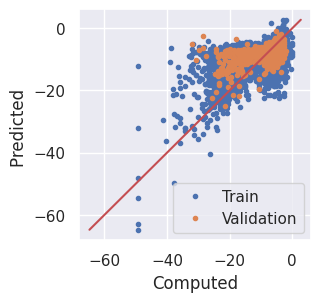

Epoch: 131, Train MAE: 2.7540, Val MAE: 3.0046
Epoch: 132, Train MAE: 2.7389, Val MAE: 3.0030
Epoch: 133, Train MAE: 2.7539, Val MAE: 3.0382
Epoch: 134, Train MAE: 2.7387, Val MAE: 3.0289
Epoch: 135, Train MAE: 2.7809, Val MAE: 3.0490


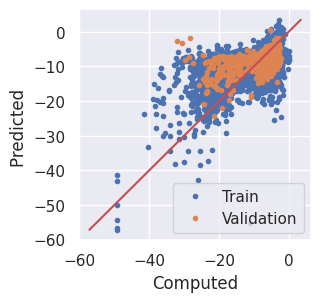

Epoch: 136, Train MAE: 2.7912, Val MAE: 3.0714
Epoch: 137, Train MAE: 2.7582, Val MAE: 3.0178
Epoch: 138, Train MAE: 2.7467, Val MAE: 3.0523
Epoch: 139, Train MAE: 2.8003, Val MAE: 2.9900
Epoch: 140, Train MAE: 2.7521, Val MAE: 3.0418


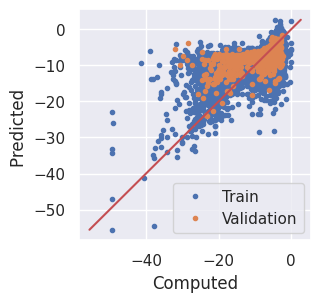

Epoch: 141, Train MAE: 2.7534, Val MAE: 3.0051
Epoch: 142, Train MAE: 2.7276, Val MAE: 3.0229
Epoch: 143, Train MAE: 2.7279, Val MAE: 3.0257
Epoch: 144, Train MAE: 2.7531, Val MAE: 3.0499
Epoch: 145, Train MAE: 2.7376, Val MAE: 3.0260


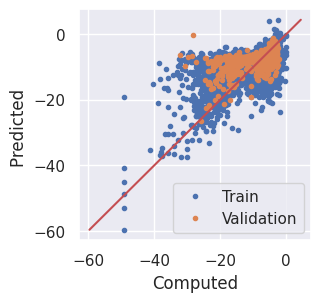

Epoch: 146, Train MAE: 2.7248, Val MAE: 3.0043
Epoch: 147, Train MAE: 2.7256, Val MAE: 3.0102
Epoch: 148, Train MAE: 2.7188, Val MAE: 3.0083
Epoch: 149, Train MAE: 2.7372, Val MAE: 3.0544
Epoch: 150, Train MAE: 2.7465, Val MAE: 3.0106


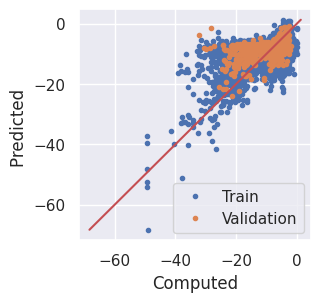

Epoch: 151, Train MAE: 2.7043, Val MAE: 2.9984
Epoch: 152, Train MAE: 2.7285, Val MAE: 3.0121
Epoch: 153, Train MAE: 2.7308, Val MAE: 3.0286
Epoch: 154, Train MAE: 2.7285, Val MAE: 3.0280
Epoch: 155, Train MAE: 2.7220, Val MAE: 2.9979


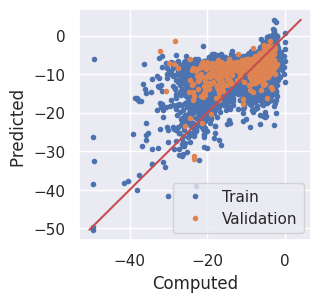

Epoch: 156, Train MAE: 2.7247, Val MAE: 3.0133
Epoch: 157, Train MAE: 2.7488, Val MAE: 3.0086
Epoch: 158, Train MAE: 2.7521, Val MAE: 3.0296
Epoch: 159, Train MAE: 2.7328, Val MAE: 3.0285
Epoch: 160, Train MAE: 2.7191, Val MAE: 2.9988


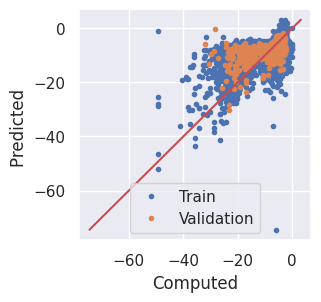

Epoch: 161, Train MAE: 2.8095, Val MAE: 3.0110
Epoch: 162, Train MAE: 2.7437, Val MAE: 3.0191
Epoch: 163, Train MAE: 2.7493, Val MAE: 2.9654
Epoch: 164, Train MAE: 2.7211, Val MAE: 2.9887
Epoch: 165, Train MAE: 2.7454, Val MAE: 3.0388


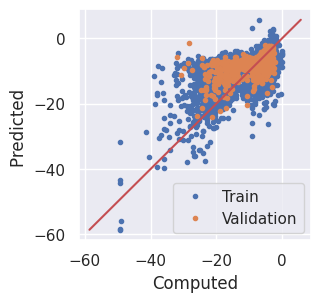

Epoch: 166, Train MAE: 2.7151, Val MAE: 2.9767
Epoch: 167, Train MAE: 2.7078, Val MAE: 3.0094
Epoch: 168, Train MAE: 2.7007, Val MAE: 3.0085
Epoch: 169, Train MAE: 2.7072, Val MAE: 3.0092
Epoch: 170, Train MAE: 2.7204, Val MAE: 2.9899


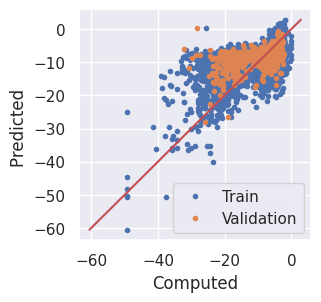

Epoch: 171, Train MAE: 2.6952, Val MAE: 2.9940
Epoch: 172, Train MAE: 2.7150, Val MAE: 3.0257
Epoch: 173, Train MAE: 2.7053, Val MAE: 2.9732
Epoch: 174, Train MAE: 2.7103, Val MAE: 3.0342
Epoch: 175, Train MAE: 2.7022, Val MAE: 3.0211


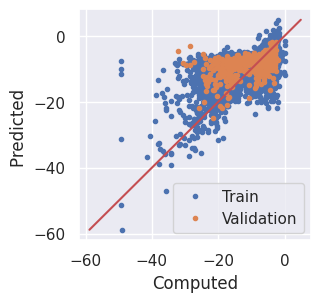

Epoch: 176, Train MAE: 2.7115, Val MAE: 3.0215
Epoch: 177, Train MAE: 2.6954, Val MAE: 2.9918
Epoch: 178, Train MAE: 2.7368, Val MAE: 3.0268
Epoch: 179, Train MAE: 2.6962, Val MAE: 3.0246
Epoch: 180, Train MAE: 2.6777, Val MAE: 2.9762


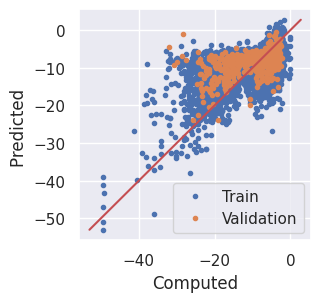

Epoch: 181, Train MAE: 2.6989, Val MAE: 2.9991
Epoch: 182, Train MAE: 2.7346, Val MAE: 3.0085
Epoch: 183, Train MAE: 2.6907, Val MAE: 3.0224
Epoch: 184, Train MAE: 2.6930, Val MAE: 2.9966
Epoch: 185, Train MAE: 2.6715, Val MAE: 2.9856


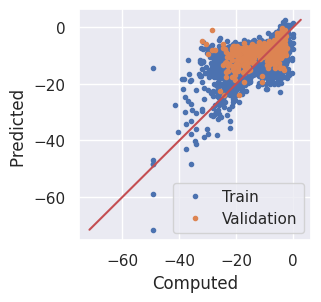

Epoch: 186, Train MAE: 2.6916, Val MAE: 3.0269
Epoch: 187, Train MAE: 2.6983, Val MAE: 2.9954
Epoch: 188, Train MAE: 2.7143, Val MAE: 3.0472
Epoch: 189, Train MAE: 2.6972, Val MAE: 3.0270
Epoch: 190, Train MAE: 2.7011, Val MAE: 3.0361


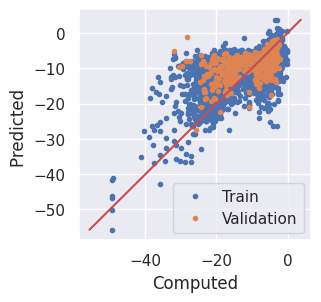

Epoch: 191, Train MAE: 2.6763, Val MAE: 2.9997
Epoch: 192, Train MAE: 2.6670, Val MAE: 3.0198
Epoch: 193, Train MAE: 2.6632, Val MAE: 3.0406
Epoch: 194, Train MAE: 2.6689, Val MAE: 3.0055
Epoch: 195, Train MAE: 2.6886, Val MAE: 3.0317


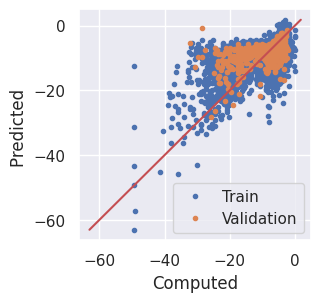

Epoch: 196, Train MAE: 2.6838, Val MAE: 2.9903
Epoch: 197, Train MAE: 2.6580, Val MAE: 3.0072
Epoch: 198, Train MAE: 2.6674, Val MAE: 2.9767
Epoch: 199, Train MAE: 2.6810, Val MAE: 3.0168
Epoch: 200, Train MAE: 2.6856, Val MAE: 3.0304


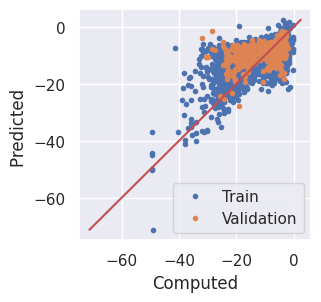

Epoch: 201, Train MAE: 2.6664, Val MAE: 3.0499
Epoch: 202, Train MAE: 2.6626, Val MAE: 2.9945
Epoch: 203, Train MAE: 2.7068, Val MAE: 3.0316
Epoch: 204, Train MAE: 2.6810, Val MAE: 3.0880
Epoch: 205, Train MAE: 2.7267, Val MAE: 3.0451


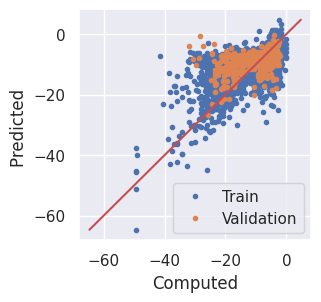

Epoch: 206, Train MAE: 2.6669, Val MAE: 3.0611
Epoch: 207, Train MAE: 2.6562, Val MAE: 3.0415
Epoch: 208, Train MAE: 2.6656, Val MAE: 3.0485
Epoch: 209, Train MAE: 2.6679, Val MAE: 3.0416
Epoch: 210, Train MAE: 2.7126, Val MAE: 3.0443


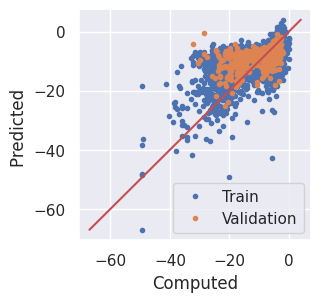

Epoch: 211, Train MAE: 2.6940, Val MAE: 3.0309
Epoch: 212, Train MAE: 2.6567, Val MAE: 3.0436
Epoch: 213, Train MAE: 2.6511, Val MAE: 3.0306
Epoch: 214, Train MAE: 2.6943, Val MAE: 3.1157
Epoch: 215, Train MAE: 2.6764, Val MAE: 3.0424


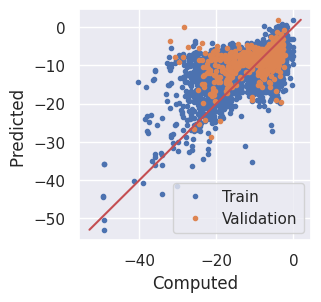

Epoch: 216, Train MAE: 2.6643, Val MAE: 3.0728
Epoch: 217, Train MAE: 2.6757, Val MAE: 3.0254
Epoch: 218, Train MAE: 2.6784, Val MAE: 3.0264
Epoch: 219, Train MAE: 2.6466, Val MAE: 3.0485
Epoch: 220, Train MAE: 2.6644, Val MAE: 3.0173


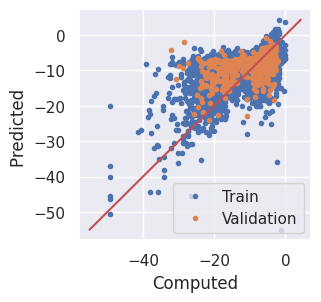

Epoch: 221, Train MAE: 2.7016, Val MAE: 3.0722
Epoch: 222, Train MAE: 2.6951, Val MAE: 3.0600
Epoch: 223, Train MAE: 2.6825, Val MAE: 3.0434
Epoch: 224, Train MAE: 2.6613, Val MAE: 3.0473
Epoch: 225, Train MAE: 2.6481, Val MAE: 3.0139


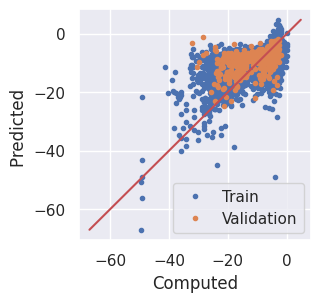

Epoch: 226, Train MAE: 2.7155, Val MAE: 3.0758
Epoch: 227, Train MAE: 2.6734, Val MAE: 3.0252
Epoch: 228, Train MAE: 2.6468, Val MAE: 3.0704
Epoch: 229, Train MAE: 2.6468, Val MAE: 2.9767
Epoch: 230, Train MAE: 2.6587, Val MAE: 3.0719


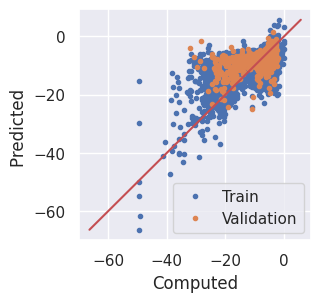

Epoch: 231, Train MAE: 2.6382, Val MAE: 3.0706
Epoch: 232, Train MAE: 2.6608, Val MAE: 3.0298
Epoch: 233, Train MAE: 2.6789, Val MAE: 3.0133
Epoch: 234, Train MAE: 2.6336, Val MAE: 3.0412
Epoch: 235, Train MAE: 2.6510, Val MAE: 3.0197


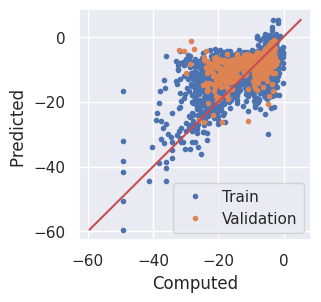

Epoch: 236, Train MAE: 2.6426, Val MAE: 3.0986
Epoch: 237, Train MAE: 2.6436, Val MAE: 3.0456
Epoch: 238, Train MAE: 2.6825, Val MAE: 3.0737
Epoch: 239, Train MAE: 2.6538, Val MAE: 3.0035
Epoch: 240, Train MAE: 2.6508, Val MAE: 3.0083


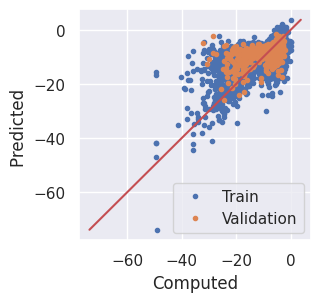

Epoch: 241, Train MAE: 2.6463, Val MAE: 3.0071
Epoch: 242, Train MAE: 2.6712, Val MAE: 3.0669
Epoch: 243, Train MAE: 2.6333, Val MAE: 3.0439
Epoch: 244, Train MAE: 2.6591, Val MAE: 3.0646
Epoch: 245, Train MAE: 2.6165, Val MAE: 3.0491


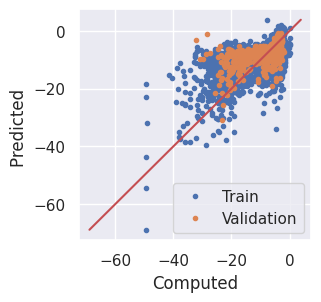

Epoch: 246, Train MAE: 2.6750, Val MAE: 3.0072
Epoch: 247, Train MAE: 2.6514, Val MAE: 3.0550
Epoch: 248, Train MAE: 2.6705, Val MAE: 3.0894
Epoch: 249, Train MAE: 2.6527, Val MAE: 3.0176
Epoch: 250, Train MAE: 2.6531, Val MAE: 3.0597


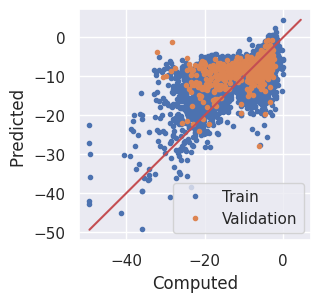

Epoch: 251, Train MAE: 2.6220, Val MAE: 3.0719
Epoch: 252, Train MAE: 2.6684, Val MAE: 3.0705
Epoch: 253, Train MAE: 2.6381, Val MAE: 3.0523
Epoch: 254, Train MAE: 2.6461, Val MAE: 3.0509
Epoch: 255, Train MAE: 2.6258, Val MAE: 3.0299


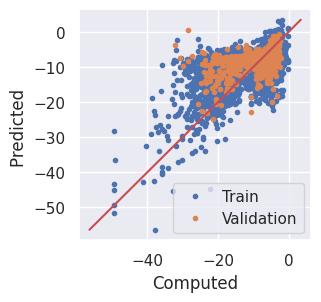

Epoch: 256, Train MAE: 2.6459, Val MAE: 3.0622
Epoch: 257, Train MAE: 2.6048, Val MAE: 3.0697
Epoch: 258, Train MAE: 2.6228, Val MAE: 3.0536
Epoch: 259, Train MAE: 2.6296, Val MAE: 3.0526
Epoch: 260, Train MAE: 2.6347, Val MAE: 3.0654


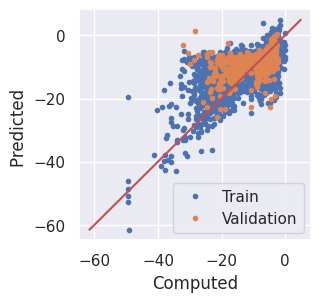

Epoch: 261, Train MAE: 2.6256, Val MAE: 3.1215
Epoch: 262, Train MAE: 2.6478, Val MAE: 3.0037
Epoch: 263, Train MAE: 2.6365, Val MAE: 3.0619
Epoch: 264, Train MAE: 2.5883, Val MAE: 3.0306
Epoch: 265, Train MAE: 2.6092, Val MAE: 3.0485


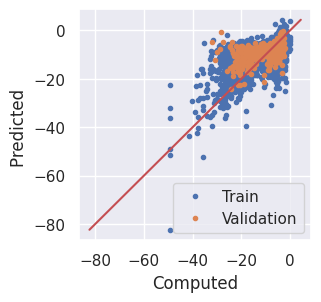

Epoch: 266, Train MAE: 2.6470, Val MAE: 3.0431
Epoch: 267, Train MAE: 2.6155, Val MAE: 3.0655
Epoch: 268, Train MAE: 2.6118, Val MAE: 3.0532
Epoch: 269, Train MAE: 2.6307, Val MAE: 3.0629
Epoch: 270, Train MAE: 2.6254, Val MAE: 3.1118


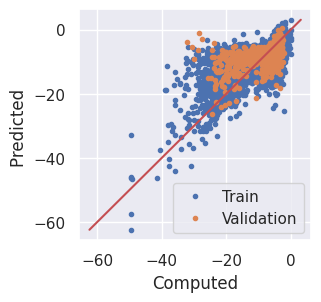

Epoch: 271, Train MAE: 2.6034, Val MAE: 3.0623
Epoch: 272, Train MAE: 2.6020, Val MAE: 3.1051
Epoch: 273, Train MAE: 2.7121, Val MAE: 3.0444
Epoch: 274, Train MAE: 2.6695, Val MAE: 3.0519
Epoch: 275, Train MAE: 2.6466, Val MAE: 3.1169


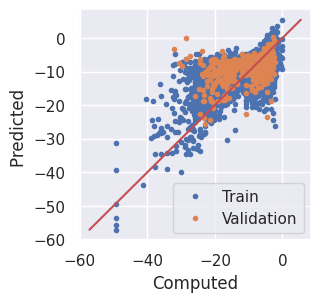

Epoch: 276, Train MAE: 2.6016, Val MAE: 3.0712
Epoch: 277, Train MAE: 2.6009, Val MAE: 3.0788
Epoch: 278, Train MAE: 2.5818, Val MAE: 3.1100
Epoch: 279, Train MAE: 2.5895, Val MAE: 3.0722
Epoch: 280, Train MAE: 2.6358, Val MAE: 3.0590


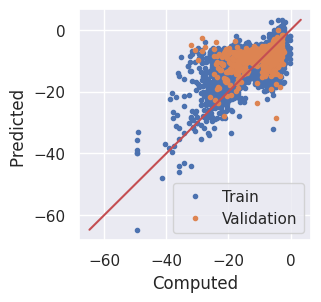

Epoch: 281, Train MAE: 2.6014, Val MAE: 3.1019
Epoch: 282, Train MAE: 2.6199, Val MAE: 3.0696
Epoch: 283, Train MAE: 2.6156, Val MAE: 3.0491
Epoch: 284, Train MAE: 2.6091, Val MAE: 3.1143
Epoch: 285, Train MAE: 2.6194, Val MAE: 3.1021


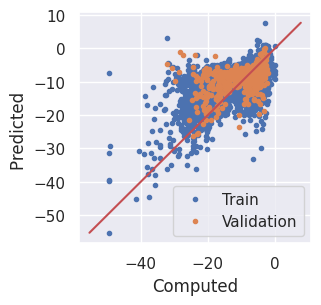

Epoch: 286, Train MAE: 2.6483, Val MAE: 3.0573
Epoch: 287, Train MAE: 2.6419, Val MAE: 3.0535
Epoch: 288, Train MAE: 2.5995, Val MAE: 3.0977
Epoch: 289, Train MAE: 2.6156, Val MAE: 3.0535
Epoch: 290, Train MAE: 2.6073, Val MAE: 3.0524


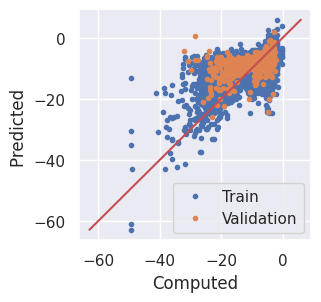

Epoch: 291, Train MAE: 2.6146, Val MAE: 3.0670
Epoch: 292, Train MAE: 2.6727, Val MAE: 3.0640
Epoch: 293, Train MAE: 2.6326, Val MAE: 3.0589
Epoch: 294, Train MAE: 2.6132, Val MAE: 3.0465
Epoch: 295, Train MAE: 2.6087, Val MAE: 3.0601


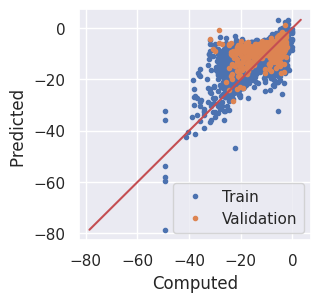

Epoch: 296, Train MAE: 2.5753, Val MAE: 3.0144
Epoch: 297, Train MAE: 2.6060, Val MAE: 3.1028
Epoch: 298, Train MAE: 2.6064, Val MAE: 3.0781
Epoch: 299, Train MAE: 2.5908, Val MAE: 3.0555
Epoch: 300, Train MAE: 2.6176, Val MAE: 3.0428


In [8]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = train(model, criterion, train_loader,
                                                               target_factor.to(device),
                                                               standardized_parameters['target_mean'].to(device),
                                                               optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  test(model, criterion, val_loader,
                                                               target_factor.to(device),
                                                               standardized_parameters['target_mean'].to(device))

    # Pass to energy units (same as initial Fv)
    train_loss = np.sqrt(train_loss) * target_factor.item()
    val_loss   = np.sqrt(val_loss)   * target_factor.item()

    if epoch%5 == 0:
        stack = np.concatenate([train_predictions, train_ground_truths,
                                val_predictions,   val_ground_truths])
    
        _min_ = np.min(stack)
        _max_ = np.max(stack)
    
        plt.figure(figsize=(3, 3))
        plt.plot(train_ground_truths, train_predictions, '.', label='Train')
        plt.plot(val_ground_truths,   val_predictions,   '.', label='Validation')
        plt.xlabel(r'Computed')
        plt.ylabel(r'Predicted ')
        plt.plot([_min_, _max_], [_min_, _max_], '-r')
        plt.legend(loc='best')
        plt.show()
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

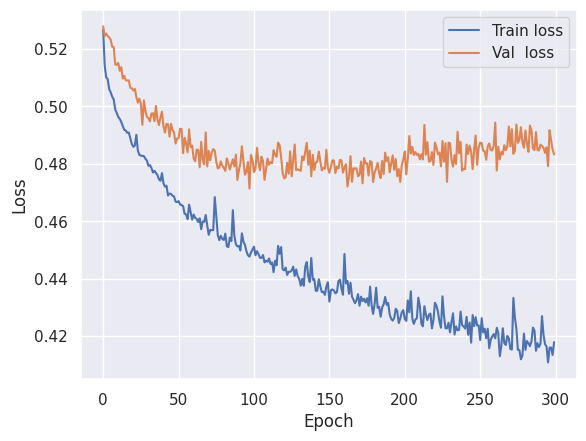

In [9]:
plt.plot(np.log10(train_losses), label='Train loss')
plt.plot(np.log10(val_losses) , label='Val  loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# Check test data

In [29]:
# Load Graph Neural Network model
model = clm.GCNN(features_channels=n_node_features, pdropout=dropout)

# Moving model to device
model = model.to(device)

# Load Graph Neural Network model
model.load_state_dict(torch.load(f'{target_folder}/{target}-model.pt', map_location=torch.device(device)))
model.eval()  # Evaluation mode, drops out dropouts

/tmp/ipykernel_652427/3130139249.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{target_folder}/{target}-model.pt', map_location=torc

GCNN(
  (conv1): GraphConv(4, 32)
  (conv2): GraphConv(32, 32)
  (linconv1): Linear(in_features=32, out_features=32, bias=True)
  (linconv2): Linear(in_features=32, out_features=16, bias=True)
  (lin): Linear(in_features=16, out_features=1, bias=True)
)

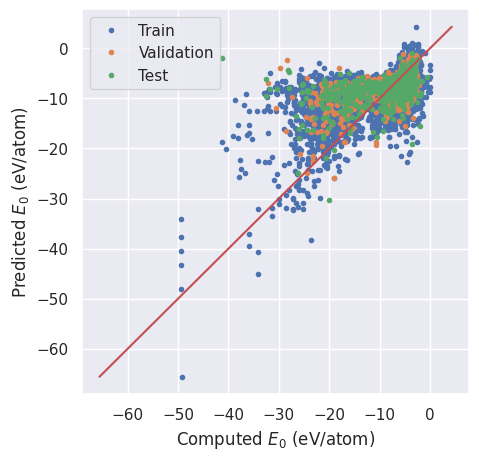

Train MAE: 2.7205, Val MAE: 2.9610, Test MAE: 3.1766


In [30]:
train_loss, train_predictions, train_ground_truths = test(model, criterion, train_loader,
                                                          target_factor.to(device),
                                                          standardized_parameters['target_mean'].to(device))
val_loss,   val_predictions,   val_ground_truths   =  test(model, criterion, val_loader,
                                                           target_factor.to(device),
                                                           standardized_parameters['target_mean'].to(device))
test_loss,  test_predictions,  test_ground_truths  =  test(model, criterion, test_loader,
                                                           target_factor.to(device),
                                                           standardized_parameters['target_mean'].to(device))

# Pass to energy units (same as initial Fv)
train_loss = np.sqrt(train_loss) * target_factor.item()
val_loss   = np.sqrt(val_loss)   * target_factor.item()
test_loss  = np.sqrt(test_loss)  * target_factor.item()

stack = np.concatenate([train_predictions, train_ground_truths,
                        val_predictions,   val_ground_truths,
                        test_predictions,  test_ground_truths])

_min_ = np.min(stack)
_max_ = np.max(stack)

plt.figure(figsize=(5, 5))
plt.xlabel(r'Computed $E_0$ (eV/atom)')
plt.ylabel(r'Predicted $E_0$ (eV/atom)')
plt.plot(train_ground_truths, train_predictions, '.', label='Train')
plt.plot(val_ground_truths,   val_predictions,   '.', label='Validation')
plt.plot(test_ground_truths,  test_predictions,  '.', label='Test')
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.legend(loc='best')
plt.savefig(f'{target_folder}/{target}-GCNN-training.pdf', dpi=dpi, bbox_inches='tight')
plt.show()

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')

In [31]:
loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

loss, predictions, ground_truths = test(model, criterion, loader,
                                        target_factor.to(device),
                                        standardized_parameters['target_mean'].to(device))

uncertainties = ground_truths - predictions
uncertainties

array([ 0.552639  , -0.9501562 ,  0.6451616 , ..., -0.8977585 ,
        1.8537464 , -0.91661024], dtype=float32)

In [33]:
# Generate dictionnary with uncertinty data
# label: uncertainty = ground-truth - prediction
uncertainty_data = {}
for idx, label in enumerate(train_labels):
    uncertainty_data.update(
        {label: float(uncertainties[idx])}
    )

# Dump the dictionary with numpy arrays to a JSON file
with open(f'{target_folder}/uncertainty_data.json', 'w') as json_file:
    json.dump(uncertainty_data, json_file)  